<a href="https://colab.research.google.com/github/AAEO04/final-year-project/blob/main/final_year_project_lowcarbonsteelweld0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

In [2]:
!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00


In [3]:
import os
import shutil
import requests
import zipfile
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input # Specific import for ResNet
# from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input # If using MobileNetV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
from tf_explain.core.grad_cam import GradCAM

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
!git clone https://github.com/stefyste/RIAWELC.git
from pathlib import Path # Import the Path object from pathlib
DATASET_BASE_DIR = Path("RIAWELC")

Cloning into 'RIAWELC'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 528 (delta 4), reused 103 (delta 0), pack-reused 382 (from 1)
Receiving objects: 100% (528/528), 471.32 MiB | 23.61 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (20/20), done.


In [5]:
import os
import subprocess
from pathlib import Path

# --- Configuration ---
# Path to the directory containing  .part*.rar files
source_rar_dir = Path("/content/RIAWELC/Dataset_partitioned")
# Path to  the extracted data
output_extracted_dir = Path("/content/RIAWELC/RIAWELC_extracted_unrar")
# The name of the first part of the RAR archive
first_rar_filename = "RIAWELC_dataset.part01.rar"
# Full path to the first RAR file
first_rar_file = source_rar_dir / first_rar_filename

# --- Installation  ---
# Run this cell once if unrar is not available
# !apt-get update
# !apt-get install unrar -y

# --- Create Output Directory ---
# Ensure the output directory exists
os.makedirs(output_extracted_dir, exist_ok=True)
print(f"Ensuring output directory exists: {output_extracted_dir}")

# --- Extraction using unrar ---
print(f"\nStarting extraction of {first_rar_file} to {output_extracted_dir} using unrar...")

try:
    # The 'x' flag extracts with full paths
    # The command is run from the current directory, so we use the full path to the rar file
    # We specify the output directory as the last argument
    result = subprocess.run(
        ['unrar', 'x', str(first_rar_file), str(output_extracted_dir)],
        check=True, # Raise CalledProcessError if command returns non-zero exit code
        capture_output=True, # Capture stdout and stderr
        text=True # Decode output as text
    )
    print("unrar stdout:\n", result.stdout)
    print("unrar stderr:\n", result.stderr)
    print("\nExtraction command finished.")

except FileNotFoundError:
    print("Error: 'unrar' command not found. Please run the installation cell.")
except subprocess.CalledProcessError as e:
    print(f"Error during unrar extraction: {e}")
    print("Stderr:", e.stderr)
    print("Stdout:", e.stdout)
except Exception as e:
    print(f"An unexpected error occurred during extraction: {e}")


# --- Verification Check ---
print("\nVerifying extraction...")

if output_extracted_dir.exists():
    print(f"Output directory exists: {output_extracted_dir}")

    # Check if the directory is not empty
    if any(output_extracted_dir.iterdir()):
        print("Output directory is NOT empty. Extraction likely successful.")
        # You can list contents to verify
        # print("\nContents of extracted directory:")
        # !ls -R "{output_extracted_dir}" # Use !ls for shell command output

        # --- Optional: More specific check ---
        # If you know a specific file or folder that should exist after extraction,
        # you can check for its presence. For example, checking for the 'training' folder:
        expected_subdir = output_extracted_dir / "RIAWELC" # Adjust based on actual extracted structure
        if expected_subdir.exists():
             print(f"Expected subdirectory found: {expected_subdir}")
             # You might check for training/testing inside this
             # if (expected_subdir / "training").exists() and (expected_subdir / "testing").exists():
             #     print("Training and testing subdirectories found.")
        else:
             print(f"Warning: Expected subdirectory '{expected_subdir}' not found.")


    else:
        print("Output directory is EMPTY. Extraction may have failed or archive was empty.")
else:
    print("Output directory does NOT exist. Extraction failed.")

print("\nVerification complete.")


Streaming output truncated to the last 5000 lines.
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[23][24].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[23][28].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[24][17].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[26][34].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[28][33].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[28][35].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[28][38].png

In [6]:
import os
import shutil
from pathlib import Path

# Define the paths
base_dir = Path("/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy")  # Path to your dataset
data_splits = ["training", "testing", "validation"]  # Data splits to process

# Define the folder mapping
folder_mapping = {
    "Difetto1": "LP",
    "Difetto2": "PO",
    "Difetto4": "CR",
    "NoDifetto": "ND",
}

# Loop through data splits and rename folders
for split in data_splits:
    split_dir = base_dir / split
    for old_name, new_name in folder_mapping.items():
        old_folder = split_dir / old_name
        new_folder = split_dir / new_name
        if old_folder.exists():
            shutil.move(str(old_folder), str(new_folder))
            print(f"Renamed '{old_folder}' to '{new_folder}'")
        else:
            print(f"Folder '{old_folder}' not found.")

print("Folder renaming complete.")

Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/Difetto1' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/LP'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/Difetto2' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/PO'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/Difetto4' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/CR'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/NoDifetto' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/ND'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/Difetto1' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/LP'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/Difetto2' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/PO'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/Difetto4' to '/content/RIAWELC/RIAWELC_extracted_unra

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

print("All libraries imported successfully.")

All libraries imported successfully.


In [8]:
BASE_DATA_DIR = "/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "training")
VALIDATION_DIR = os.path.join(BASE_DATA_DIR, "validation")
TEST_DIR = os.path.join(BASE_DATA_DIR, "testing")

IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
CLASS_NAMES = ['LP', 'PO', 'CR', 'ND']

if all(os.path.exists(dir) for dir in [TRAIN_DIR, VALIDATION_DIR, TEST_DIR]):
    print("All dataset directories exist.")
else:
    print("Warning: One or more dataset directories are missing.")

All dataset directories exist.


In [9]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

Found 15863 images belonging to 4 classes.
Found 6101 images belonging to 4 classes.
Found 2443 images belonging to 4 classes.


In [10]:
# --- Model Definition ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

#to freeze all layers initailly
for layer in base_model.layers:
    layer.trainable = False

#Unfreeze a portion of the later layers for fine-tuning.
# 30 layers as a  starting point,will  adjust if overfitting continues .
num_layers_to_unfreeze = 30
if num_layers_to_unfreeze > len(base_model.layers):
    num_layers_to_unfreeze = len(base_model.layers)
    print(f"Warning: num_layers_to_unfreeze exceeds total layers. Unfreezing all {num_layers_to_unfreeze} layers.")

for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)

# --- ADDED: Dropout layer for regularization ---
# Reduces overfitting by randomly setting a fraction of input units to 0 at each update during training.
x = Dense(1024, activation='relu')(x) # Keep the dense layer size, but add dropout
x = Dropout(0.5)(x) # Add Dropout with a rate of 50%

predictions = Dense(len(CLASS_NAMES), activation='softmax')(x) # Final classification layer

# Combine base model and new layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Display the model architecture
model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 16,552,452 (63.14 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [11]:
# --- Model Compilation ---
# Using Adam optimizer and categorical crossentropy loss for multi-class classification.
# Metrics include accuracy, precision, and recall. F1 score will be calculated via sklearn later.
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    # Removed F1Score from compile metrics to use sklearn's version later for clarity
)

print("Model compiled successfully.")





Model compiled successfully.


In [12]:
# --- Callbacks ---
# EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ModelCheckpoint to save the best model based on validation loss
# Using the recommended .keras format
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

print("Callbacks defined successfully.")


Callbacks defined successfully.


In [ ]:
# --- Model Training ---
print("Starting training...")
EPOCHS = 50 # set at the max you want
# Calculate steps per epoch and validation steps
#steps_per_epoch = train_generator.samples // train_generator.batch_size
#validation_steps = val_generator.samples // val_generator.batch_size
#if steps_per_epoch == 0:
 #   steps_per_epoch = 1 # Ensure at one step if dataset is small
#if validation_steps == 0:
 #   validation_steps = 1

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    #steps_per_epoch=steps_per_epoch,
    #validation_steps=validation_steps
)

print("Training completed.")


Starting training...
Epoch 1/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 240s 483ms/step - accuracy: 0.5404 - loss: 1.0207 - precision: 0.6763 - recall: 0.3524 - val_accuracy: 0.3499 - val_loss: 6.1586 - val_precision: 0.3480 - val_recall: 0.3339
Epoch 2/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 233s 470ms/step - accuracy: 0.5825 - loss: 0.9615 - precision: 0.6959 - recall: 0.4154 - val_accuracy: 0.2918 - val_loss: 3.8950 - val_precision: 0.2873 - val_recall: 0.2777
Epoch 3/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 231s 465ms/step - accuracy: 0.6389 - loss: 0.8784 - precision: 0.7319 - recall: 0.5000 - val_accuracy: 0.3509 - val_loss: 5.1183 - val_precision: 0.3519 - val_recall: 0.3452
Epoch 4/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 261s 464ms/step - accuracy: 0.6440 - loss: 0.8625 - precision: 0.7375 - recall: 0.5216 - val_accuracy: 0.2885 - val_loss: 5.0875 - val_precision: 0.2888 - val_recall: 0.2881
Epoch 5/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 231s 465ms/step - accuracy: 0.6649 - loss: 0.8216 - precision: 0.7563 - recall: 0.5

Generating training history plots...


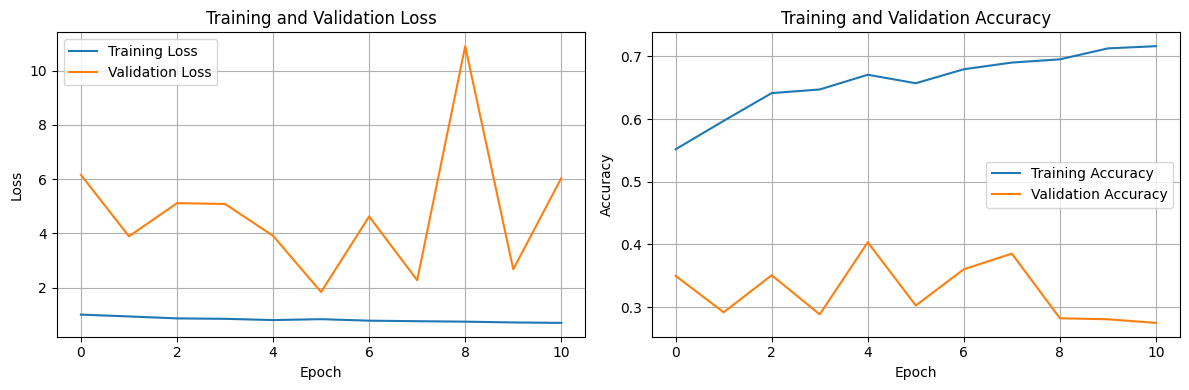

Training history plots generated.


In [15]:
# --- Training History Plots  ---
if 'history' in locals(): # Check if history object exists
    print("Generating training history plots...")
    plt.figure(figsize=(12, 4))
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Training history plots generated.")
else:
    print("Skipping history plots as 'history' object not found (training likely skipped).")

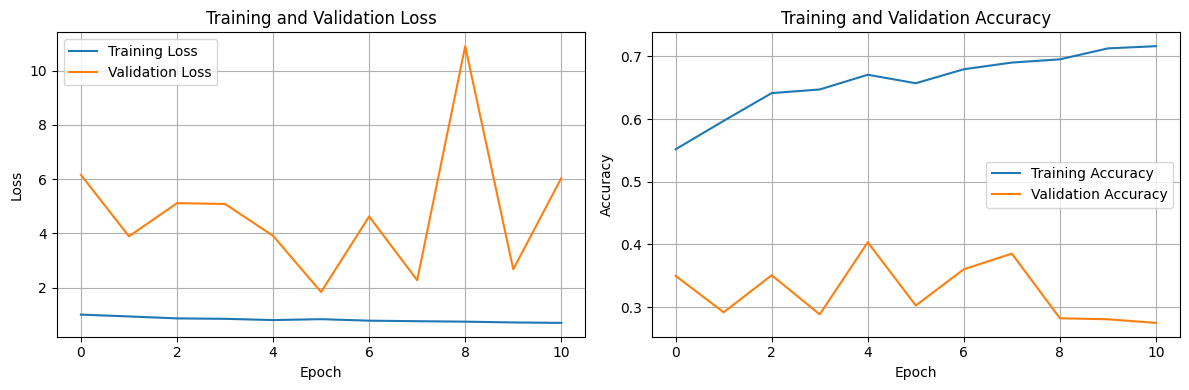

Training history plots generated.


In [16]:
# --- Training History Plots ---
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history plots generated.")

In [17]:
# --- Model Evaluation (Load best model if training was skipped) ---
# Ensure the best model is loaded for evaluation
model_path = 'best_model.keras'
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found. Please train the model first or provide the correct path.")
else:
    try:
        # Load the best model saved by ModelCheckpoint
        print(f"Loading best model from {model_path} for evaluation...")
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
        # Re-compile might be needed if optimizer state is crucial for evaluation metrics beyond loss/accuracy
        model.compile(loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

        print("\nEvaluating model on test data...")
        test_generator.reset() # Reset generator before evaluation
        evaluation_results = model.evaluate(test_generator)
        test_loss = evaluation_results[0]
        test_acc = evaluation_results[1]
        test_precision = evaluation_results[2] # Index depends on metrics order during compile
        test_recall = evaluation_results[3]    # Index depends on metrics order during compile
        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")

        print("\nGenerating predictions for detailed evaluation metrics...")
        test_generator.reset() # Reset again before predicting
        # Ensure prediction steps cover the entire test set
        steps = (test_generator.samples + test_generator.batch_size - 1) // test_generator.batch_size
        y_pred_probs = model.predict(test_generator, steps=steps)
        # Take only the number of predictions corresponding to the samples
        y_pred_probs = y_pred_probs[:test_generator.samples]
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true = test_generator.classes

        if len(y_true) != len(y_pred_classes):
             print(f"Warning: Mismatch between number of true labels ({len(y_true)}) and predictions ({len(y_pred_classes)}).")
        else:
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

            cm = confusion_matrix(y_true, y_pred_classes)
            print("\nConfusion Matrix:")
            print(cm)

            print("\nPer-Class Accuracy:")
            class_accuracies = cm.diagonal() / cm.sum(axis=1)
            for i, class_name in enumerate(CLASS_NAMES):
                print(f"{class_name}: {class_accuracies[i]:.4f}")

            if len(CLASS_NAMES) > 1:
                print("\nCalculating ROC-AUC (One-vs-Rest)...")
                try:
                    y_true_bin = label_binarize(y_true, classes=np.arange(len(CLASS_NAMES)))
                    roc_auc = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr', average='macro')
                    print(f"ROC-AUC (One-vs-Rest, Macro-Averaged): {roc_auc:.4f}")
                except ValueError as e:
                    print(f"Could not calculate ROC-AUC. Error: {e}")

                print("\nCalculating Precision-Recall Curves and Average Precision...")
                plt.figure(figsize=(10, 8))
                y_true_bin = label_binarize(y_true, classes=np.arange(len(CLASS_NAMES)))
                for i, class_name in enumerate(CLASS_NAMES):
                     if np.sum(y_true_bin[:, i]) > 0:
                        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
                        ap = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
                        plt.plot(recall, precision, lw=2, label=f'{class_name} (AP = {ap:.2f})')
                     else:
                         print(f"Skipping PR curve for class '{class_name}' due to no true instances.")
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.title('Precision-Recall Curve for Each Class')
                plt.legend(loc='best')
                plt.grid(True)
                plt.show()

            print("\nCalculating Cohen's Kappa...")
            kappa = cohen_kappa_score(y_true, y_pred_classes)
            print(f"Cohen’s Kappa: {kappa:.4f}")

            print("\nGenerating Confusion Matrix plot...")
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

    except Exception as e:
        print(f"An error occurred during evaluation: {e}")

print("\nModel evaluation section finished.")

Loading best model from best_model.keras for evaluation...
Model loaded successfully.

Evaluating model on test data...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.4704 - loss: 1.1913 - precision_1: 0.5059 - recall_1: 0.4349

Test Loss: 1.8097
Test Accuracy: 0.3078
Test Precision: 0.3429
Test Recall: 0.2685

Generating predictions for detailed evaluation metrics...
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step

Classification Report:
              precision    recall  f1-score   support

          LP       0.30      0.56      0.39       765
          PO       0.29      0.41      0.34       632
          CR       0.91      0.07      0.13       446
          ND       0.34      0.06      0.10       600

    accuracy                           0.31      2443
   macro avg       0.46      0.27      0.24      2443
weighted avg       0.42      0.31      0.26      2443


Confusion Matrix:
[[425 295   3  42]
 [356 262   0  14]
 [135 270  31  10]
 [489  77   0  34]]

Per-Class Accuracy:
LP: 0.5556
PO: 0.4146
CR: 0.0695
ND: 0.0567

Calculating ROC-AUC (One-vs-Rest)...
An error occurred during evaluation: nam

# Grad-CAM Implementation for Weld Defect Classification

This section implements Gradient-weighted Class Activation Mapping (Grad-CAM) to visualize the regions of the input weld images that the trained ResNet50 model focuses on when making a classification.

**Weld Quality Assessment Note:**
* **Interpretation:** Grad-CAM helps understand *why* the model predicts a specific defect type (LP, PO, CR) or 'No Defect' (ND). Analyzing these heatmaps provides insight into whether the model is identifying relevant features, indirectly contributing to quality assessment by verifying the model's reasoning.
* **Confidence Score:** The output probability for the 'ND' class from the model's final layer can serve as a basic confidence score for good weld quality. A higher probability suggests the model is more confident the weld is defect-free.
* **Dedicated Feature:** To add a specific numerical quality score output, the model architecture would need modification (e.g., adding a regression head) and retraining with data labeled for quality scores.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2 # OpenCV for image handling
from tf_explain.core.grad_cam import GradCAM # Import GradCAM explainer
import os # To handle file paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Re-import if needed
from pathlib import Path # Re-import if needed

# --- Ensure necessary variables from previous cells are defined ---
# These might need to be re-run if the notebook kernel was restarted
try:
    print(f"Using BASE_DATA_DIR: {BASE_DATA_DIR}")
    print(f"Using TEST_DIR: {TEST_DIR}")
    print(f"Using IMG_SIZE: {IMG_SIZE}")
    print(f"Using CLASS_NAMES: {CLASS_NAMES}")
    print(f"Using BATCH_SIZE: {BATCH_SIZE}")
except NameError as e:
    print(f"Error: A required variable is not defined ({e}). Please re-run the cells defining dataset paths, image size, class names, and batch size.")
    # Example re-definitions (ensure these match your setup):
    # BASE_DATA_DIR = "/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/"
    # TEST_DIR = os.path.join(BASE_DATA_DIR, "testing")
    # IMG_WIDTH, IMG_HEIGHT = 224, 224
    # IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
    # BATCH_SIZE = 32
    # CLASS_NAMES = ['LP', 'PO', 'CR', 'ND']

# Redefine the generator used for preprocessing consistency
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Recreate the test generator - IMPORTANT: shuffle=False
test_generator_for_xai = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, # Adjust batch size if needed for memory
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False # Important!
)

print("Required libraries imported and test generator configured for XAI.")

Using BASE_DATA_DIR: /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/
Using TEST_DIR: /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing
Using IMG_SIZE: (224, 224)
Using CLASS_NAMES: ['LP', 'PO', 'CR', 'ND']
Using BATCH_SIZE: 32
Found 2443 images belonging to 4 classes.
Required libraries imported and test generator configured for XAI.


In [20]:
# --- Load the Trained Model ---
model_path = 'best_model.keras' # Path to your saved best model
if not os.path.exists(model_path):
    print(f"Error: Model file not found at '{model_path}'. Please ensure the model was trained and saved, or adjust the path.")
    model = None # Set model to None if loading fails
else:
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        # Optional: Re-compile if needed for certain operations, usually not required just for predict/explain
        # model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        model = None

if model:
    model.summary() # Display summary to help verify layer names

Model loaded successfully from best_model.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,794,894 (224.28 MB)

 Trainable params: 16,552,452 (63.14 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

 Optimizer params: 33,104,906 (126.29 MB)

### Identify Last Convolutional Layer

Find the name of the last convolutional layer *before* the `GlobalAveragePooling2D` layer in the `model.summary()` output above. For a standard ResNet50, this is often `'conv5_block3_out'`. **Verify and update the `last_conv_layer_name` variable in the next cell if it's different.**

In [21]:
### Cell 23 (Replacement): Automatically Identify Last Convolutional Layer

import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Activation, Add, BatchNormalization

last_conv_layer_name = None
suitable_layer_found = False

if 'model' in locals() and model is not None:
    print("Attempting to automatically find the last convolutional layer before GlobalAveragePooling2D...")

    # Find the GlobalAveragePooling2D layer
    gap_layer_index = -1
    for i, layer in enumerate(model.layers):
        if isinstance(layer, GlobalAveragePooling2D):
            gap_layer_index = i
            break

    if gap_layer_index != -1 and gap_layer_index > 0:
        # Get the layer immediately preceding the GAP layer
        potential_layer = model.layers[gap_layer_index - 1]
        # Check if it's a typical output layer of a conv block (Conv, Activation, Add, BN)
        # In ResNet50, it's usually the final Activation ('conv5_block3_out')
        if isinstance(potential_layer, (Conv2D, Activation, Add, BatchNormalization)):
            last_conv_layer_name = potential_layer.name
            suitable_layer_found = True
            print(f"Automatically identified layer name: '{last_conv_layer_name}' (Type: {type(potential_layer).__name__})")
        else:
            print(f"Warning: Layer immediately before GAP ('{potential_layer.name}') is type {type(potential_layer).__name__}.")
            # Fallback: Search backwards from before GAP for the last Conv2D or Activation
            for layer in reversed(model.layers[:gap_layer_index]):
                if isinstance(layer, (Conv2D, Activation)):
                    last_conv_layer_name = layer.name
                    suitable_layer_found = True
                    print(f"Fallback: Using preceding layer '{last_conv_layer_name}' (Type: {type(layer).__name__})")
                    break
            if not suitable_layer_found:
                 print("Warning: Could not find a typical Conv2D or Activation layer before GAP using fallback search.")

    elif gap_layer_index == 0:
         print("Error: GlobalAveragePooling2D layer is the first layer?")
    else:
        print("Error: GlobalAveragePooling2D layer not found in the model.")
        # Fallback: Try finding the very last Conv2D layer in the entire model
        for layer in reversed(model.layers):
             if isinstance(layer, Conv2D):
                 last_conv_layer_name = layer.name
                 suitable_layer_found = True
                 print(f"Fallback: Using the absolute last Conv2D layer found: '{last_conv_layer_name}'")
                 break

    if not suitable_layer_found:
         last_conv_layer_name = 'conv5_block3_out' # Default guess for ResNet50
         print(f"\nError: Automatic identification failed.")
         print(f"Setting default '{last_conv_layer_name}'. **PLEASE VERIFY** this name using model.summary() before running Grad-CAM.")

elif 'model' not in locals() or model is None:
    print("Error: Model is not loaded. Cannot identify the layer.")
    last_conv_layer_name = 'conv5_block3_out' # Provide default guess
    print(f"Warning: Setting default layer name '{last_conv_layer_name}'. Model needs to be loaded first.")

# Ensure the variable is usable in the next cell
if last_conv_layer_name:
     print(f"\n==> Layer to be used for Grad-CAM: {last_conv_layer_name}")
else:
     print("\n==> CRITICAL ERROR: last_conv_layer_name could not be determined. Manual setting required.")

Attempting to automatically find the last convolutional layer before GlobalAveragePooling2D...
Automatically identified layer name: 'conv5_block3_out' (Type: Activation)

==> Layer to be used for Grad-CAM: conv5_block3_out


### Generate and Display Grad-CAM Visualizations

This cell takes a few sample images from the test set, runs Grad-CAM, and displays the results. The heatmap shows areas the model found important for its prediction.

Processing 5 images from batch 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Image 1 (RRT-101R_Img1_A80_S4_[16][1].png):
  True Label: LP
  Predicted Label: LP (Confidence: 0.5839)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


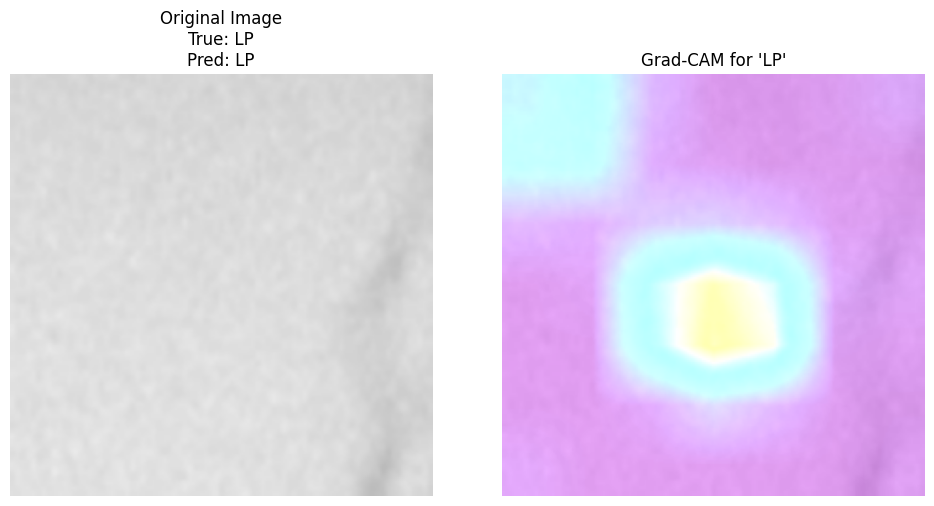

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Image 2 (RRT-101R_Img1_A80_S4_[19][7].png):
  True Label: LP
  Predicted Label: PO (Confidence: 0.5139)


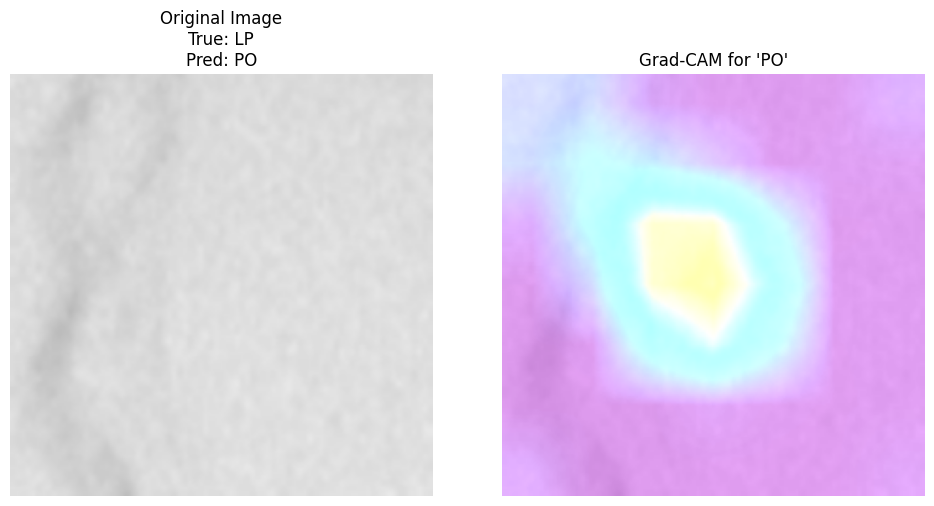

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Image 3 (RRT-101R_Img1_A80_S4_[25][3].png):
  True Label: LP
  Predicted Label: LP (Confidence: 0.6096)


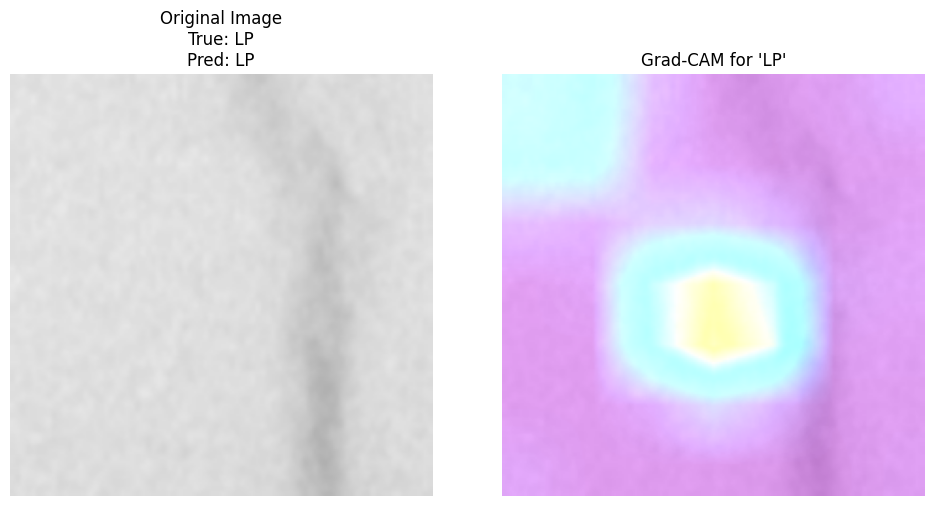

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Image 4 (RRT-101R_Img1_A80_S4_[26][4].png):
  True Label: LP
  Predicted Label: LP (Confidence: 0.6261)


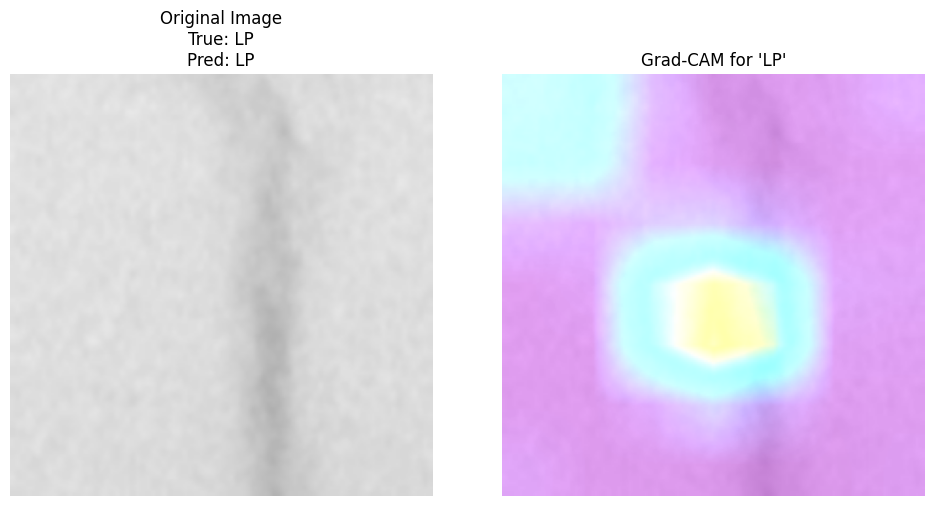

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Image 5 (RRT-101R_Img1_A80_S4_[26][6].png):
  True Label: LP
  Predicted Label: LP (Confidence: 0.6786)


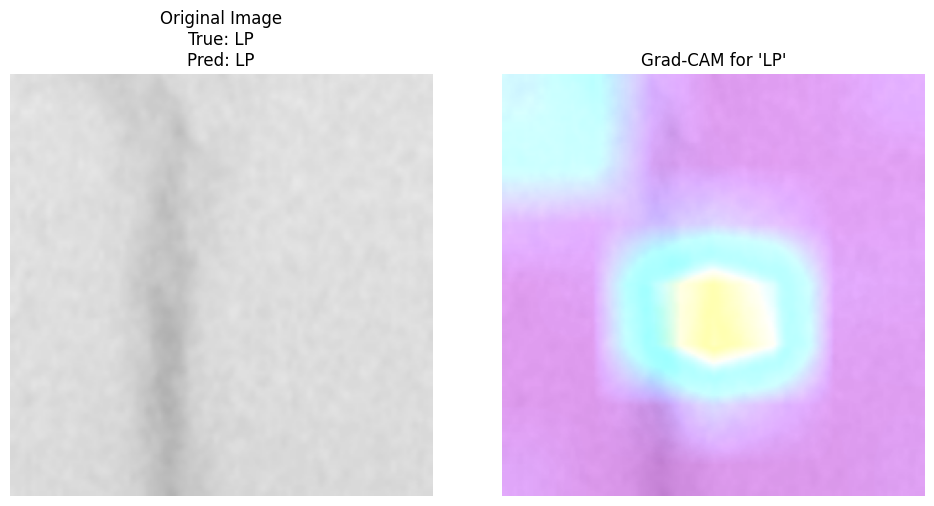


Grad-CAM visualization finished.


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tf_explain.core.grad_cam import GradCAM

if model is None:
    print("Model not loaded. Cannot generate Grad-CAM.")
else:
    # --- Get a batch of images and filenames from the test generator ---
    test_generator_for_xai.reset()
    try:
        images, labels = next(test_generator_for_xai)
        # Get corresponding filenames for the batch
        # Note: Accessing filenames directly like this depends on the generator's state and batch size.
        # It gets filenames for the *current* batch.
        current_batch_index = test_generator_for_xai.batch_index -1 # We just called next(), so index is previous batch
        if current_batch_index < 0: current_batch_index = 0
        start_index = current_batch_index * test_generator_for_xai.batch_size
        end_index = start_index + images.shape[0]
        batch_filenames = [os.path.join(TEST_DIR, test_generator_for_xai.filenames[k])
                           for k in range(start_index, end_index)]

        num_images_to_show = min(5, images.shape[0]) # Show up to 5 images
        print(f"Processing {num_images_to_show} images from batch {current_batch_index+1}...")
    except StopIteration:
        print("Test generator is exhausted. Cannot get images.")
        num_images_to_show = 0
    except Exception as e:
        print(f"Error getting batch or filenames: {e}")
        num_images_to_show = 0

    if num_images_to_show > 0:
        # Initialize the GradCAM explainer
        explainer = GradCAM()

        # --- Loop through selected images ---
        for i in range(num_images_to_show):
            img_array_processed = images[i:i+1] # Get the single preprocessed image
            true_label_index = np.argmax(labels[i])
            true_label_name = CLASS_NAMES[true_label_index]
            image_path = batch_filenames[i]

            # --- Get model prediction ---
            preds = model.predict(img_array_processed)
            predicted_class_index = np.argmax(preds[0])
            predicted_class_name = CLASS_NAMES[predicted_class_index]
            prediction_confidence = np.max(preds[0])

            print(f"\nImage {i+1} ({os.path.basename(image_path)}):")
            print(f"  True Label: {true_label_name}")
            print(f"  Predicted Label: {predicted_class_name} (Confidence: {prediction_confidence:.4f})")

            # --- Generate Grad-CAM explanation ---
            try:
                 grid = explainer.explain(
                     validation_data=(img_array_processed, None),
                     model=model,
                     class_index=predicted_class_index,
                     layer_name=last_conv_layer_name
                 )

                 # --- Load original image for clearer display ---
                 original_img = cv2.imread(image_path)
                 if original_img is None:
                     print(f"  Warning: Could not reload original image {image_path} for display.")
                     # Fallback: use the rescaled image from generator (less ideal)
                     original_img_display = (img_array_processed[0] * 255).astype(np.uint8)
                 else:
                     original_img_display = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
                     original_img_display = cv2.resize(original_img_display, IMG_SIZE)

                 # --- Display using Matplotlib ---
                 plt.figure(figsize=(10, 5))
                 plt.subplot(1, 2, 1)
                 plt.imshow(original_img_display)
                 plt.title(f"Original Image\nTrue: {true_label_name}\nPred: {predicted_class_name}")
                 plt.axis('off')

                 plt.subplot(1, 2, 2)
                 plt.imshow(grid) # grid is the already superimposed image
                 plt.title(f"Grad-CAM for '{predicted_class_name}'")
                 plt.axis('off')

                 plt.tight_layout()
                 plt.show()

                 # --- Optional: Save the Grad-CAM image ---
                 # output_gradcam_path = f'gradcam_image_{i}_pred_{predicted_class_name}.png'
                 # cv2.imwrite(output_gradcam_path, cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))
                 # print(f"  Grad-CAM saved to {output_gradcam_path}")

            except Exception as e:
                 print(f"  Error generating Grad-CAM for image {i+1}: {e}")
                 print("  Skipping Grad-CAM for this image.")

        print("\nGrad-CAM visualization finished.")